### DDPM : Air Quality Dataset

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from scipy import stats
from IPython.display import display, clear_output
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [1]:
import pandas as pd
import numpy as np

# Load data with Date and Time columns
data = pd.read_csv('energy_data.csv')
features = data.drop(columns='date')

Code after taking diagnal element of the cov matrix

In [2]:
# The diffusion kernel returns the parameters of Pr(z_{t}|x)
def diffusion_kernel(x, t, beta,sigma_t):             # (current data points, current diffusion step, a noise parameter)
    alpha = np.power(1-beta,t)
    dk_mean = x * np.sqrt(alpha)                       # Mean of Diffusion Kernel
    dk_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return dk_mean, dk_std

# Beta  = Noise
# Alpha = Parameter which tell us about how much information to keep.   (alpha = 1 - Beta)

def conditional_diffusion_distribution(x, z_t, t, beta,sigma_t):    # Z_t  = Predicted value at current data point, t = current diffusion step,  beta = the noise parameter
    # Compute diffusion kernel parameters
    dk_mean, dk_std = diffusion_kernel(x, t, beta, sigma_t)
    
    # Compute conditional diffusion distribution parameters
    alpha = np.power(1 - beta, t)
    cd_mean = z_t / np.sqrt(alpha)  # Adjust the coefficient as needed          cd_mean = predicted mean at current step.
    cd_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return cd_mean, cd_std

def get_data_pairs(x_train, t, beta, sigma_t):


  # Extract diagonal elements (standard deviations) from sigma_t
  #sigma_t_diag = np.diag(sigma_t)  # Assuming sigma_t is a covariance matrix

  # Reshape sigma_t_diag for element-wise multiplication
  #sigma_t_reshaped = np.tile(sigma_t_diag, (x_train.shape[0], 1))

  # Find diffusion kernel for every x_train and draw samples (element-wise multiplication)
  dk_mean, dk_std = diffusion_kernel(x_train, t, beta, sigma_t)
  print(x_train.shape)
  z_t = dk_std * np.random.normal(size=x_train.shape) + dk_mean

  # Find conditional diffusion distribution for each x_train, z pair and draw samples
  cd_mean, cd_std = conditional_diffusion_distribution(x_train, z_t, t, beta, sigma_t)

  if t == 1:
    z_tminus1 = x_train  # If first timestep, use the training data directly
  else:
    # Sample z_tminus1 using cd_std and cd_mean (element-wise multiplication)
    z_tminus1 = cd_std * np.random.normal(size=x_train.shape) + cd_mean

  return z_t, z_tminus1



In [3]:
class NonParametricModel():
    # Constructor initializes parameters
    def __init__(self):
        self.inc = 0.01
        self.max_val = 3.0
        self.model = []

    # Learns a model that predicts z_t_minus1 given z_t
    def train(self, zt, zt_minus1):
        zt = np.clip(zt, -self.max_val, self.max_val)
        zt_minus1 = np.clip(zt_minus1, -self.max_val, self.max_val)
        bins = np.arange(-self.max_val, self.max_val + self.inc, self.inc)
        numerator, _ = np.histogram(zt, bins=bins, weights=zt_minus1 - zt)
        denominator, _ = np.histogram(zt, bins=bins)
        self.model = numerator / (denominator + 1)

    def predict(self, zt):
        bin_index = np.floor((zt + self.max_val) / self.inc).astype('int')
        bin_index = np.clip(bin_index, 0, len(self.model) - 1)
        return zt + self.model[bin_index]


### Performing Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
# Create StandardScaler object
scaler = StandardScaler()

# Fit and transform the feature dataset
scaled_df = scaler.fit_transform(features)

# Convert scaled features back to DataFrame (if needed)
scaled_data = pd.DataFrame(scaled_df, columns=features.columns)

In [6]:
# Extract dimensions
seq_len = 24  # Sequence length
num_features = scaled_data.shape[1]  # Number of columns after dropping
num_samples = len(scaled_data) - seq_len + 1  # Number of samples

# Initialize a numpy array to store the 3D array
data_3d = np.zeros((num_samples, seq_len, num_features))

# Populate the 3D array
for i in range(num_samples):
    data_3d[i] = scaled_data.values[i:i+seq_len]

print(data_3d.shape)

(19712, 24, 28)


In [7]:
num_samples, num_time_steps, num_features = data_3d.shape
data_2d = data_3d.reshape(num_samples, num_time_steps * num_features)

print(data_2d.shape)

(19712, 672)


In [8]:
import numpy as np

# Assuming data_2d is your NumPy array

# Calculate the covariance matrix
cov_matrix = np.cov(data_2d, rowvar=False)

print(cov_matrix)

[[ 0.99989137  0.19719027  0.05458584 ...  0.00367541 -0.00708951
  -0.00708951]
 [ 0.19719027  1.00089173 -0.0226793  ... -0.03890781  0.01005438
   0.01005438]
 [ 0.05458584 -0.0226793   0.99458638 ...  0.55017229 -0.00338519
  -0.00338519]
 ...
 [ 0.00367541 -0.03890781  0.55017229 ...  1.00116599 -0.00397203
  -0.00397203]
 [-0.00708951  0.01005438 -0.00338519 ... -0.00397203  1.00006366
   1.00006366]
 [-0.00708951  0.01005438 -0.00338519 ... -0.00397203  1.00006366
   1.00006366]]


In [9]:
# Extract the standard deviations from the diagonal of the covariance matrix
std_devs = np.sqrt(np.diag(cov_matrix))
std_devs

array([0.99994568, 1.00044577, 0.99728952, 0.99925653, 0.99668614,
       1.00053324, 0.99600556, 1.00046833, 0.9985419 , 0.99928511,
       0.99851015, 1.00059327, 0.99574493, 0.99887802, 0.99851018,
       0.99898696, 0.99984822, 0.99958957, 0.99865969, 0.99972027,
       0.99592529, 1.00060797, 0.99919331, 1.00035215, 0.99958156,
       0.99758048, 1.00013931, 1.00013931, 0.99994301, 1.00017527,
       0.99740919, 0.99923732, 0.99687639, 1.00050542, 0.99620746,
       1.00040767, 0.99861123, 0.99929471, 0.99854776, 1.00058907,
       0.99594372, 0.99893049, 0.99853502, 0.99901242, 0.99977253,
       0.99959447, 0.99870411, 0.99973436, 0.99611512, 1.00038339,
       0.99922558, 1.00033279, 0.99952145, 0.99771439, 1.0001305 ,
       1.0001305 , 0.99994301, 0.99990467, 0.99752626, 0.99923609,
       0.99706227, 1.00047847, 0.9964203 , 1.00034273, 0.99868053,
       0.99929423, 0.99858536, 1.00058479, 0.99614447, 0.99898325,
       0.99856118, 0.99903609, 0.99969681, 0.99959979, 0.99874

In [10]:
sigma_t = std_devs

In [13]:
x_train = data_2d

# Define model parameters
T = 800    # Diffusion Steps
beta = 0.01511
#std_random_number = 1    # Old Covariance matrix
all_models = []
sigma_t_reshaped = np.tile(sigma_t, (x_train.shape[0], 1))

for t in range(0, T):
    clear_output(wait=True)

    
    display("Training timestep %d" % (t))
    zt, zt_minus1 = get_data_pairs(x_train, t + 1, beta, sigma_t_reshaped)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to z_{t}
    all_models[t].train(zt, zt_minus1)


'Training timestep 799'

(19712, 672)


In [14]:
def sample(model, T, sigma_t, n_samples):                           
    samples = np.zeros((T + 1, n_samples, 672))  # Modify shape to include two features                       
    
    # Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T, :, :] = np.random.normal(size=(n_samples, 672))  # Generate samples for both features

    # For t = 100...99..98... ...0
    for t in range(T, 0, -1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}" % (t - 1, t))
        # Predict samples[t-1,:] from samples[t,:] using the appropriate model
        model_t_minus_1 = model[t - 1]
        samples[t - 1, :, :] = model_t_minus_1.predict(samples[t, :])

        # If not the last time step
        if t > 0:
            # Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
            noise = np.random.normal(0, sigma_t[t - 1], size=(n_samples, 672))  # Generate noise for both features
            samples[t - 1, :, :] += noise

    return samples  # Return the samples array containing the generated data for each diffusion step


In [39]:
# Assuming T is the number of diffusion steps
T = 200

# Define your sigma_t as a list of standard deviations for each diffusion step
sigma_t

# Repeat the standard deviations to cover all diffusion steps
sigma_t = np.tile(sigma_t, (T // len(sigma_t)) + 1)[:T]

# Convert sigma_t to a numpy array for compatibility with the sample function
sigma_t = np.array(sigma_t)

n_samples = 19712       # Specifies the number of samples to generate using the model.
samples = sample(all_models, T, sigma_t, n_samples) # Call the samples function to generate the new samples


# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-12,12.05,0.05)   # This line defines the bins for the histogram plot, ranging from -3 to 3 with a step size of 0.05.

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-12,12])
plt.hist(sampled_data, bins=bins, density =True)   # This line plots the histogram of the sampled data using the defined bins. The density=True argument normalizes the histogram to form a probability density.
ax.set_ylim(0, 0.8)    # This line sets the y-axis limits.
plt.show()


'Predicting z_{194} from z_{195}'

KeyboardInterrupt: 

In [20]:
synthetic_data = pd.DataFrame(sampled_data)
df_actual = data_2d

In [21]:
df_actual.shape

(19712, 672)

In [22]:
synthetic_data.shape

(19712, 672)

In [23]:
synthetic_data.head()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,-5.755698,2.889681,10.110987,12.153693,9.667393,-2.691690,2.809785,4.689850,6.020464,6.656062,...,11.183317,-21.593389,-9.485013,11.842598,-25.646425,-8.496189,-7.447602,20.231428,-7.828210,23.061964
1,-4.393871,11.026546,-11.268468,-10.786957,0.875044,-9.728374,1.441436,-11.686838,17.497995,1.546873,...,6.993227,7.899536,3.631308,-1.465657,17.925388,-2.993055,-3.310302,-2.636228,2.300323,7.539945
2,14.283027,11.074859,-10.819404,9.958616,4.094326,12.616171,-8.980832,4.876050,20.958019,3.576487,...,9.298088,-23.318892,11.608063,6.544778,-6.557440,-8.025357,-12.925463,14.164356,3.868351,-1.018435
3,-8.728751,11.390692,3.790075,11.169720,-2.246505,11.152658,-8.319542,-8.053066,7.483896,-5.136492,...,-8.422298,3.562943,4.365640,5.993389,-9.710324,-8.885914,2.882039,4.902324,-6.547651,1.911535
4,-8.522006,-3.169105,-3.540781,12.796289,-3.175658,5.185663,1.830138,6.045692,0.781409,-12.444073,...,-0.072636,-9.248069,5.632664,0.618854,13.957140,0.752974,22.172999,-6.735767,-6.300719,-17.793135


In [24]:
from sklearn.preprocessing import StandardScaler

# Create StandardScaler object
scaler =StandardScaler()

# Fit and transform the feature dataset
scaled_synthetic = scaler.fit_transform(synthetic_data)

# Convert scaled features back to DataFrame (if needed)
df_synthetic = pd.DataFrame(scaled_synthetic, columns=synthetic_data.columns)

In [25]:
print(df_synthetic.shape)
print(df_actual.shape)

(19712, 672)
(19712, 672)


### PCA Plot

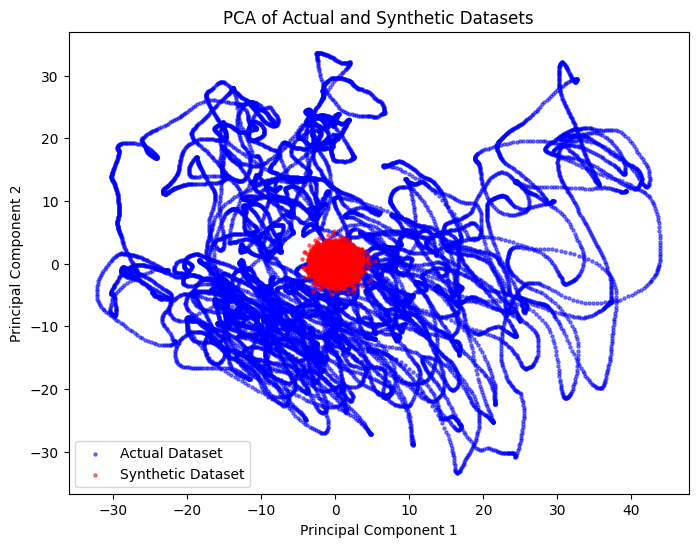

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_actual and df_synthetic are already defined


# Perform PCA on the actual dataset
pca = PCA(n_components=2)
principal_components_1 = pca.fit_transform(df_actual)

# Perform PCA on the synthetic dataset
principal_components_2 = pca.fit_transform(scaled_synthetic)

# Plot both datasets on the same graph with different colors
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_1[:, 0], principal_components_1[:, 1], s=5, alpha=0.5, label='Actual Dataset', color='blue')
plt.scatter(principal_components_2[:, 0], principal_components_2[:, 1], s=5, alpha=0.5, label='Synthetic Dataset', color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Actual and Synthetic Datasets')
plt.legend()
plt.show()

In [28]:
import numpy as np

# Converting 2D array into 3D array
# Reshape to 3D array
actual_data_3d = df_actual.reshape(-1, 24, 28)

print(actual_data_3d.shape)  


(19712, 24, 28)


In [29]:
import numpy as np

# Converting 2D array into 3D array
synthetic_data_3d = scaled_synthetic.reshape(-1, 24, 28)

print(synthetic_data_3d.shape) 

(19712, 24, 28)


### Distance Metrics

In [30]:
from IPython.display import SVG, display, Image
import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import tsgm

import numpy as np
import functools
import sklearn
import os

statistics = [
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=1),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=1)]

In [31]:
discrepancy_func = lambda x, y: np.linalg.norm(x - y)

In [32]:
dist_metric = tsgm.metrics.DistanceMetric(
    statistics=statistics, discrepancy=discrepancy_func
)
print(dist_metric(actual_data_3d, synthetic_data_3d))

15.287502512913141


In [33]:
n_samples, sequence_length, n_features = actual_data_3d.shape
reshaped_data = actual_data_3d.reshape((n_samples * sequence_length, n_features))

# Create a DataFrame from the reshaped data
columns = [f"Feature_{i+1}" for i in range(n_features)]
df_actual = pd.DataFrame(reshaped_data, columns=columns)

In [34]:
n_samples, sequence_length, n_features = synthetic_data_3d.shape
reshaped_data1 = synthetic_data_3d.reshape((n_samples * sequence_length, n_features))

# Create a DataFrame from the reshaped data
columns = [f"Feature_{i+1}" for i in range(n_features)]
df_generated = pd.DataFrame(reshaped_data1, columns=columns)

In [35]:
df_actual.columns = features.columns
df_generated.columns = features.columns

In [29]:
df_actual.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.474000,0.942983,2.211236,0.242504,0.442297,-0.010166,0.810649,0.432124,0.643258,0.641101,0.088462,0.183831,0.194881
1,0.466273,0.736807,1.939383,0.182085,0.176459,-0.254902,1.177136,0.266684,0.358574,-0.006723,0.081518,0.160400,0.194052
2,0.468849,1.070327,1.767687,0.172418,0.129719,-0.146131,1.071538,0.440002,0.350012,0.216513,0.049112,0.283414,0.194686
3,0.468849,0.991495,1.710454,0.177252,0.156010,0.013142,0.922459,0.503027,0.412086,0.498842,0.028279,0.400571,0.195622
4,0.461122,0.676167,1.502988,0.112000,-0.171174,-0.146131,1.273416,0.455759,0.210881,0.295303,0.032909,0.392761,0.195676


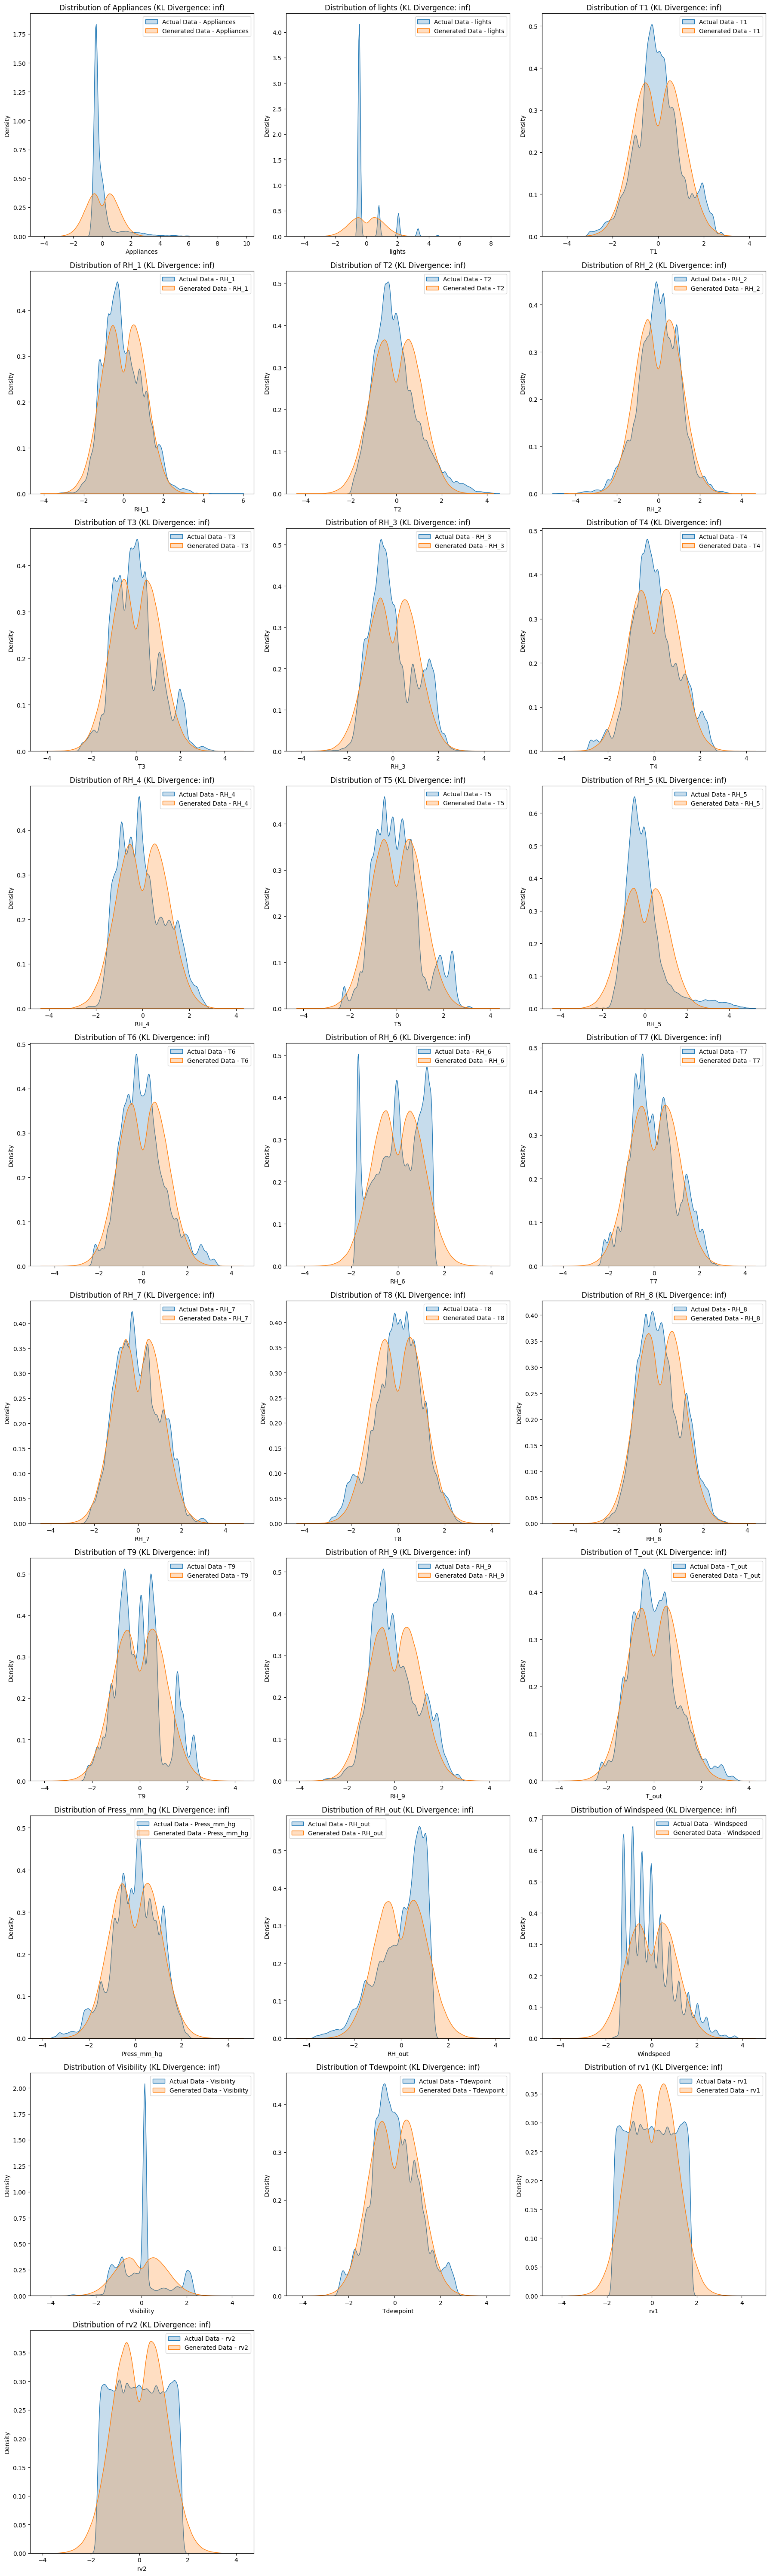

Average KL Divergence: inf


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

# Assuming df_actual and df_synthetic are your DataFrames

# Initialize a list to store KL Divergence scores
kl_divergences = []

# Number of features
num_features = len(df_actual.columns)

# Calculate the number of rows needed (3 graphs per row)
num_rows = int(np.ceil(num_features / 3))

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and corresponding subplot axis
for i, feature in enumerate(df_actual.columns):
    sns.kdeplot(df_actual[feature], label=f'Actual Data - {feature}', fill=True, ax=axes[i])
    sns.kdeplot(df_generated[feature], label=f'Generated Data - {feature}', fill=True, ax=axes[i])
    
    # Calculate KL Divergence
    kl_divergence = entropy(df_actual[feature], df_generated[feature])
    kl_divergences.append(kl_divergence)
    
    # Add title and legend
    axes[i].set_title(f'Distribution of {feature} (KL Divergence: {kl_divergence:.4f})')
    axes[i].legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Calculate average KL Divergence
average_kl_divergence = sum(kl_divergences) / len(kl_divergences)
print(f'Average KL Divergence: {average_kl_divergence:.4f}')
